## 1. 환경 준비
- .sav 파일 로드를 위한 pyreadstat 패키지 설치
- 필요한 라이브러리 임포트
- 필요한 데이터 업로드 및 드라이브 연결

In [1]:
!pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 30.1 MB/s eta 0:00:00


In [2]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from torch.nn import Linear, ReLU, Dropout, Sigmoid, Sequential, BCELoss
from pydantic import BaseModel

In [3]:
# 1. Download the 'data.zip' file from the provided link:
#     https://drive.google.com/file/d/1L9imh_EXdwVahlNOWa4F4EXLlUQT2pkS/view?usp=sharing
# 2. Upload the 'data.zip' file to your Google Drive, specifically to the 'MyDrive' folder.

drive.mount("/content/drive")
data_dir = "/content/drive/MyDrive/"

os.chdir(data_dir)
os.system("unzip data.zip")

Mounted at /content/drive


256

## 2. 데이터 관리
- load(): 파일 경로를 받아 DataFrame 으로 변환
- save(): 저장된 데이터를 .csv 로 저장
- explore(): 저장된 데이터를 탐색적으로 분석
- visualize(): 저장된 데이터를 히스토그램으로 시각화
- preprocess(): 저장된 데이터를 필요한 데이터 형태로 전처리
- split(): 저장된 데이터를 독립변수와 종속변수로 분리

In [4]:
class DataManager:
    def load(self, file_paths):
        datas = []
        for file_path in file_paths:
            try:
                df = pd.read_spss(file_path)
                datas.append(df)
            except Exception as e:
                print(f"Failed to load file: {file_path}. Error: {e}")

        self.data = pd.concat(datas, ignore_index=True)
        print("Data loaded successfully.")

    def save(self, save_path):
        if self.data is None:
            raise ValueError("No data to save. Load data first.")

        try:
            self.data.to_csv(save_path, index=False)
            print(f"Data saved successfully to {save_path}.")
        except Exception as e:
            print(f"Error saving data: {e}")

    def explore(self):
        if self.data is None:
            raise ValueError("No data to explore. Load data first.")

        print("--- Dataset Overview ---")
        print(self.data.info())
        print("\n--- Statistical Summary ---")
        print(self.data.describe())
        print("\n--- Missing Values ---")
        print(self.data.isnull().sum())

    def visualize(self):
        if self.data is None:
            raise ValueError("No data to visualize. Load data first.")

        self.data.hist(grid=False)
        plt.show()

    def preprocess(self):
        if self.data is None:
            raise ValueError("No data to preprocess. Load data first.")

        binary_data = pd.DataFrame({
            'gender': (self.data['SEX'] > 1),
            'breakfast': (self.data['F_BR'] > 1),
            'exercise': (self.data['PA_TOT'] > 1),
            'sleep': (self.data['M_SLP_EN'] > 2),
            'anxiety': (self.data[['M_GAD_1', 'M_GAD_5', 'M_GAD_7']].sum(axis=1) > 7),
            'worry': (self.data[['M_GAD_2', 'M_GAD_3']].sum(axis=1) > 5),
            'anger': (self.data[['M_GAD_4', 'M_GAD_6']].sum(axis=1) > 5),
            'depression': (self.data['M_SAD'] > 1),
            'violence': (self.data['V_TRT'] > 1),
            'thought': self.data['M_SUI_CON'],
            'plan': self.data['M_SUI_PLN'],
            'attempt': self.data['M_SUI_ATT'],
        })
        category_data = pd.DataFrame({
            'age': self.data['GRADE'],
            'stress': self.data['M_STR'],
            'loneliness': self.data['M_LON'],
            'grade': self.data['E_S_RCRD'],
            'economy': self.data['E_SES'],
            'residence': self.data['E_RES'],
        })
        columns = [
            'gender', 'age', 'breakfast', 'exercise', 'stress', 'loneliness', 'sleep', 'anxiety', 'worry', 'anger', 'depression', 'violence', 'grade', 'economy', 'residence', 'thought', 'plan', 'attempt'
        ]
        self.data = pd.concat([binary_data, category_data], axis=1)
        self.data.dropna(inplace=True)
        self.data = self.data.astype(int).reindex(columns=columns)
        self.data = pd.get_dummies(self.data, columns=['age', 'residence'], dtype=int)
        risk_weights = {'thought': 0.2, 'plan': 0.3, 'attempt': 0.5}
        self.data['risk'] = (
            self.data['thought'] * risk_weights['thought'] +
            self.data['plan'] * risk_weights['plan'] +
            self.data['attempt'] * risk_weights['attempt'] - 1
        )
        self.data.drop(columns=['thought', 'plan', 'attempt'], inplace=True)

        print("Preprocessing completed.")

    def split(self):
        if self.data is None:
            raise ValueError("No data to split. Load data first.")

        if 'risk' not in self.data.columns:
            raise ValueError(f"Target column 'risk' not found in data. Preprocess data first.")

        X = self.data.drop(columns=['risk'])
        y = self.data['risk']
        return X, y

## 3. 모델 관리
- __init__(): 모델 선언
- load(): 파일 경로를 받아 모델 로드
- save(): 저장된 모델을 .pth 로 저장
- train(): 모델 학습
- evaluate(): 모델 평가
- predict(): 독립변수를 받아 종속변수 산출

In [5]:
class ModelManager:
    def __init__(self):
        self.model = Sequential(
            Linear(24, 64), ReLU(), Dropout(0.3),
            Linear(64, 32), ReLU(), Dropout(0.2),
            Linear(32, 16), ReLU(),
            Linear(16, 1), Sigmoid()
        )

    def load(self, file_path):
        try:
            self.model.load_state_dict(torch.load(file_path, weights_only=False))
            print(f"Model loaded successfully.")
        except Exception as e:
            print(f"Failed to load model: {file_path}. Error: {e}")

    def save(self, save_path):
        try:
            torch.save(self.model.state_dict(), save_path)
            print(f"Model saved successfully to {save_path}.")
        except Exception as e:
            print(f"Error saving model: {e}")

    def train(self, X, y, lr=0.001, epochs=100):
        X = torch.tensor(X.values, dtype=torch.float32)
        y = torch.tensor(y.values, dtype=torch.float32)

        self.model.train()
        criterion = BCELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr)

        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = self.model(X).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    def evaluate(self, X, y):
        X = torch.tensor(X.values, dtype=torch.float32)
        y = torch.tensor(y.values, dtype=torch.float32)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X).squeeze()

        log_loss = -torch.mean(y * torch.log(outputs) + (1 - y) * torch.log(1 - outputs))
        brier_score = ((outputs - y) ** 2).mean().item()
        print(f"Log Loss: {log_loss}, Brier Score: {brier_score}")

    def predict(self, X):
        X = torch.tensor(X.values, dtype=torch.float32)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X).squeeze()

        result = round(outputs.item() * 100, 4)
        return result

## 4. 서비스 설계
- 요청:
  - 당신의 성별은 무엇인가요?
  - 당신의 학년은 어떻게 되나요?
  - 최근 7일간 아침식사를 한 적이 있나요?
  - 최근 7일간 숨이 찰 정도로 운동을 한 적이 있나요?
  - 평상시 스트레스를 얼마나 느끼고 있나요?
  - 평상시 외로움을 얼마나 느끼고 있나요?
  - 평상시 충분한 수면을 취하고 있나요?
  - 심각한 불안감을 자주 느끼나요?
  - 심각한 걱정을 자주 하나요?
  - 짜증이 쉽게 나고 불편한 감정이 자주 드나요?
  - 최근 2주간 일상생활이 어려울 정도로 우울해진 경험이 있나요?
  - 최근 1년간 물리적 폭력을 당하여 입원한 경험이 있나요?
  - 학업 성적은 어떤가요?
  - 가정의 경제적 상황은 어떤가요?
  - 현재 거주형태는 어떤가요?
- 응답:
  - 위험도
  - 필요한 조치

In [6]:
class Request(BaseModel):
    gender: int  # 0,1 -> 남성, 여성
    age: int  # 1,2,3,4,5,6 -> 중1, 중2, 중3, 고1, 고2, 고3
    breakfast: int  # 0,1 -> 안했다, 했다
    exercise: int  # 0,1 -> 안했다, 했다
    stress: int  # 1,2,3,4,5 -> 대단히 많이 느낀다, 많이 느낀다, 조금 느낀다, 별로 느끼지 않는다, 전혀 느끼지 않는다
    loneliness: int  # 1,2,3,4,5 -> 전혀 느끼지 않는다, 거의 느끼지 않는다, 가끔 느낀다, 자주 느낀다, 항상 느낀다
    sleep: int  # 0,1 -> 충분하다, 충분하지 않다
    anxiety: int  # 0,1 -> 자주 느끼지는 않는다, 자주 느낀다
    worry: int  # 0,1 -> 자주 하지는 않는다, 자주 한다
    anger: int  # 0,1 -> 자주 들지는 않는다, 자주 든다
    depression: int  # 0,1 -> 없다, 있다
    violence: int  # 0,1 -> 없다, 있다
    grade: int  # 1,2,3,4,5 -> 상위권, 중상위권, 중위권, 중하위권, 하위권
    economy: int  # 1,2,3,4,5 -> 풍족하다, 여유롭다, 평범하다, 빠듯하다, 부족하다
    residence: int  # 1,2,3,4,5 -> 본가, 친가/외가, 하숙/자취, 기숙사, 보육시설

class Response(BaseModel):
    risk: float
    solution: str

In [7]:
solution = [
    "현재 큰 위험은 없어 보이지만, 감정 체크를 꾸준히 하시면 좋겠어요.",
    "경미한 위험이 감지돼요. 상담을 통해 감정을 나누어 보는 것도 도움이 될 수 있어요.",
    "위험이 존재할 수 있어요. 전문가와 상담을 고려해보세요.",
    "불안정한 상태일 수 있어요. 전문가와 상담을 받는 것이 필요해 보여요.",
    "위험이 중간 정도예요. 상담을 통해 도움을 받는 것이 중요해요.",
    "위험이 꽤 심각할 수 있어요. 빠르게 전문가와 상담을 받는 것이 좋겠어요.",
    "매우 높은 위험이 감지돼요. 즉시 심리적 지원을 받는 것이 필요해요.",
    "생명에 위험이 있을 수 있어요. 긴급히 24시간 상담 서비스에 연락하세요.",
    "즉각적인 위험 신호예요. 전문가의 도움을 빠르게 받는 것이 중요해요.",
    "생명에 위협이 될 수 있어요. 지금 바로 응급실이나 24시간 상담 서비스(1588-9191)에 연락하세요",
    "항상 당신의 안전이 우선이에요. 어려운 상황이라면 언제든 전문가에게 도움을 요청하세요."
]

In [8]:
def result(model: ModelManager, data: Request) -> Response:
    data = pd.DataFrame([dict(data)])
    for i in range(1, 7):
        data[f"age_{i}"] = int(i == data['age'].iloc[0])
    for i in range(1, 6):
        data[f"residence_{i}"] = int(i == data['residence'].iloc[0])
    data.drop(columns=['age', 'residence'], inplace=True)

    outputs = model.predict(data)
    return Response(risk=outputs, solution=solution[int(outputs)//10])

## 5. 훈련 데이터 준비
- 원시 데이터 탐색
- 전처리된 데이터 탐색
- 전처리된 데이터 시각화
- 독립변수 및 종속변수 분리, 탐색

In [9]:
train_data = DataManager()
train_data.load([f"{data_dir}kyrbs{year}.sav" for year in range(2020, 2023)])
train_data.explore()

Data loaded successfully.
--- Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161646 entries, 0 to 161645
Columns: 262 entries, OBS to DR_HAB_PUR
dtypes: float64(250), object(12)
memory usage: 323.1+ MB
None

--- Statistical Summary ---
             CLUSTER              W            FPC           YEAR  \
count  161646.000000  161646.000000  161646.000000  161646.000000   
mean      400.345805      48.566924      73.907372    2020.980835   
std       227.669785      21.967501      40.480445       0.812605   
min         1.000000       2.056122       6.000000    2020.000000   
25%       207.000000      33.079267      47.000000    2020.000000   
50%       401.000000      46.815770      65.000000    2021.000000   
75%       592.000000      61.304588      95.000000    2022.000000   
max       800.000000     240.833333     193.000000    2022.000000   

               PR_HT          PR_BI         PR_HD           F_BR  \
count  161646.000000  161646.000000  54948.000000 

In [10]:
train_data.preprocess()
train_data.explore()

Preprocessing completed.
--- Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
Index: 161641 entries, 0 to 161645
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   gender       161641 non-null  int64  
 1   breakfast    161641 non-null  int64  
 2   exercise     161641 non-null  int64  
 3   stress       161641 non-null  int64  
 4   loneliness   161641 non-null  int64  
 5   sleep        161641 non-null  int64  
 6   anxiety      161641 non-null  int64  
 7   worry        161641 non-null  int64  
 8   anger        161641 non-null  int64  
 9   depression   161641 non-null  int64  
 10  violence     161641 non-null  int64  
 11  grade        161641 non-null  int64  
 12  economy      161641 non-null  int64  
 13  age_1        161641 non-null  int64  
 14  age_2        161641 non-null  int64  
 15  age_3        161641 non-null  int64  
 16  age_4        161641 non-null  int64  
 17  age_5        161641 no

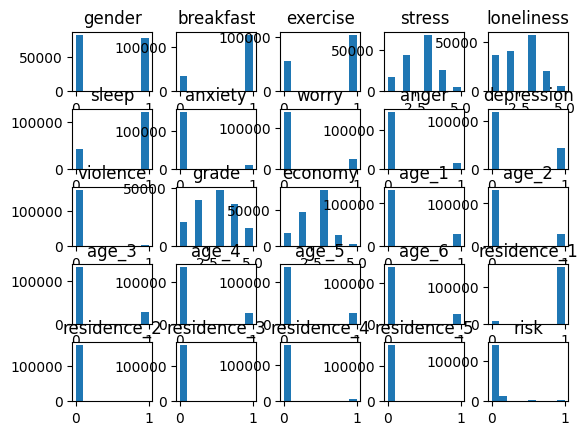

In [11]:
train_data.visualize()

In [12]:
X_train, y_train = train_data.split()
print(X_train.shape, y_train.shape)
print(X_train.head(), y_train.head())

(161641, 24) (161641,)
   gender  breakfast  exercise  stress  loneliness  sleep  anxiety  worry  \
0       0          1         0       3           2      1        0      0   
1       0          1         1       4           1      1        0      0   
2       0          1         1       3           1      0        0      0   
3       0          1         0       3           1      0        0      0   
4       1          0         1       4           3      1        0      0   

   anger  depression  ...  age_2  age_3  age_4  age_5  age_6  residence_1  \
0      0           0  ...      0      0      0      0      0            1   
1      0           0  ...      0      0      0      0      0            1   
2      0           0  ...      0      0      0      0      0            1   
3      0           0  ...      0      0      0      0      0            1   
4      0           1  ...      0      0      0      0      0            1   

   residence_2  residence_3  residence_4  residence

## 6. 모델 준비
- 모델 학습
- 테스트 데이터 준비
- 모델 평가

In [13]:
model = ModelManager()
model.train(X_train, y_train, epochs=200)

Epoch [10/200], Loss: 0.6184
Epoch [20/200], Loss: 0.4723
Epoch [30/200], Loss: 0.3035
Epoch [40/200], Loss: 0.2221
Epoch [50/200], Loss: 0.2216
Epoch [60/200], Loss: 0.2078
Epoch [70/200], Loss: 0.1993
Epoch [80/200], Loss: 0.1910
Epoch [90/200], Loss: 0.1840
Epoch [100/200], Loss: 0.1781
Epoch [110/200], Loss: 0.1730
Epoch [120/200], Loss: 0.1690
Epoch [130/200], Loss: 0.1661
Epoch [140/200], Loss: 0.1649
Epoch [150/200], Loss: 0.1636
Epoch [160/200], Loss: 0.1621
Epoch [170/200], Loss: 0.1616
Epoch [180/200], Loss: 0.1606
Epoch [190/200], Loss: 0.1601
Epoch [200/200], Loss: 0.1597


In [14]:
test_data = DataManager()
test_data.load([f"{data_dir}kyrbs2023.sav"])
test_data.preprocess()
X_test, y_test = test_data.split()
print(X_test.shape, y_test.shape)

Data loaded successfully.
Preprocessing completed.
(52873, 24) (52873,)


In [15]:
model.evaluate(X_test, y_test)

Log Loss: 0.1784740537405014, Brier Score: 0.024540184065699577


## 7. 실행
- 김현호의 상태를 샘플로 실행
- 나제준의 상태를 샘플로 실행

In [16]:
example_request = Request(
    gender=0,
    age=5,
    breakfast=1,
    exercise=0,
    stress=2,
    loneliness=3,
    sleep=1,
    anxiety=0,
    worry=1,
    anger=0,
    depression=0,
    violence=0,
    grade=4,
    economy=3,
    residence=1
)
print(result(model, example_request))

risk=3.1222 solution='현재 큰 위험은 없어 보이지만, 감정 체크를 꾸준히 하시면 좋겠어요.'


In [17]:
example_request = Request(
    gender=0,
    age=5,
    breakfast=1,
    exercise=1,
    stress=3,
    loneliness=1,
    sleep=1,
    anxiety=0,
    worry=1,
    anger=0,
    depression=0,
    violence=0,
    grade=2,
    economy=3,
    residence=1
)
print(result(model, example_request))

risk=0.4343 solution='현재 큰 위험은 없어 보이지만, 감정 체크를 꾸준히 하시면 좋겠어요.'
